**Datasets:**
`<clean/noisy>-<noise level in mm>-<filter>-<pid/dwa>-<strategy>-<g/r>-<before/after>-<no>.csv`
3. Noise: 0 position, 5 degrees orientation; filter: 0.01 position, 5 orientation.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union
import warnings

warnings.filterwarnings('ignore')

START_FROM = 0 # 100: 2790 500: 6090
NO_ROWS = 8000  # Limit window to be analysed (up to 8000 rows, ~ 2.5 mins)
X_AXES = np.arange(NO_ROWS)

CLEAN = "clean-dwa-pc-r-3.csv"
NOISY = "noisy-10-dwa-pc-r-3.csv"
NOISY_KALMAN = "noisy-10-kalman-dwa-pc-r-3.csv"

X_COL, Y_COL, TH_COL, V_COL = "x", "y", "orientation", "vector"
COLS = [X_COL, Y_COL, TH_COL]


def format_data(filename: str) -> pd.DataFrame:
    data = pd.read_csv(filename)
    return data[COLS].iloc[START_FROM : (START_FROM + NO_ROWS)]


CLEAN_FD = format_data(CLEAN)
NOISY_FD = format_data(NOISY)
NOISY_KALMAN_FD = format_data(NOISY_KALMAN)

In [ ]:
def percentage_diff(
    old: float,
    new: float
) -> float:
    return round((new-old) / old * 100, 1)


def circular_diff(t: float, a: float) -> float:
    return (t - a + np.pi) % (2 * np.pi) - np.pi


def circular_diff_squared(t: float, a: float) -> float:
    return circular_diff(t, a) ** 2


def circular_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str
) -> pd.DataFrame:        
    return true_data[param].combine(
            other=actual_data[param],
            func=circular_diff_squared
        )


def mean_circular_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str
) -> float:
    return circular_squared_error(true_data, actual_data, param).mean()

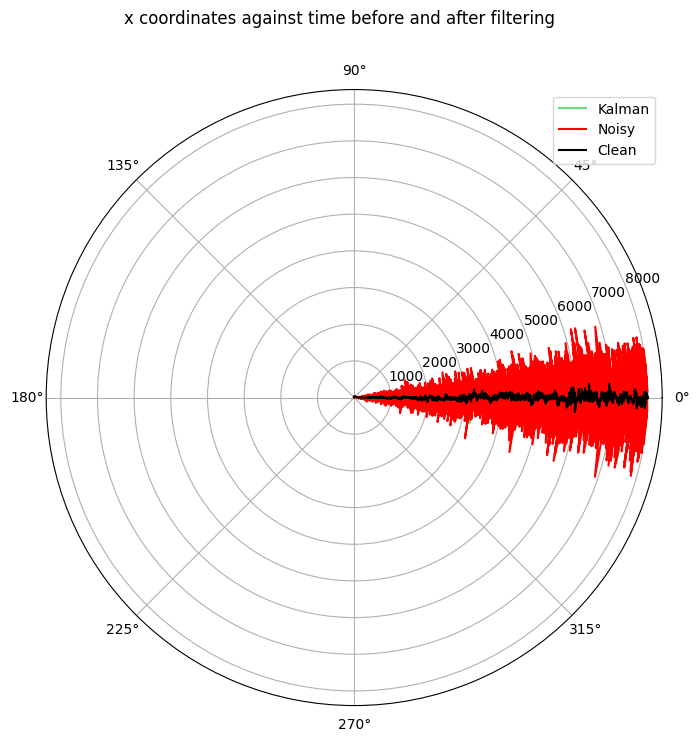

In [7]:
fig, axs = plt.subplots(subplot_kw={'projection': 'polar'})
fig.set_size_inches(12,8)
fig.suptitle("x coordinates against time before and after filtering")

axs.plot(NOISY_KALMAN_FD[TH_COL], X_AXES, "#6bdb79")
axs.plot(NOISY_FD[TH_COL], X_AXES, "r")
axs.plot(CLEAN_FD[TH_COL], X_AXES, "k")

axs.legend(("Kalman", "Noisy", "Clean"))
axs.grid(True)

[Text(0, 0, '-54.1')]

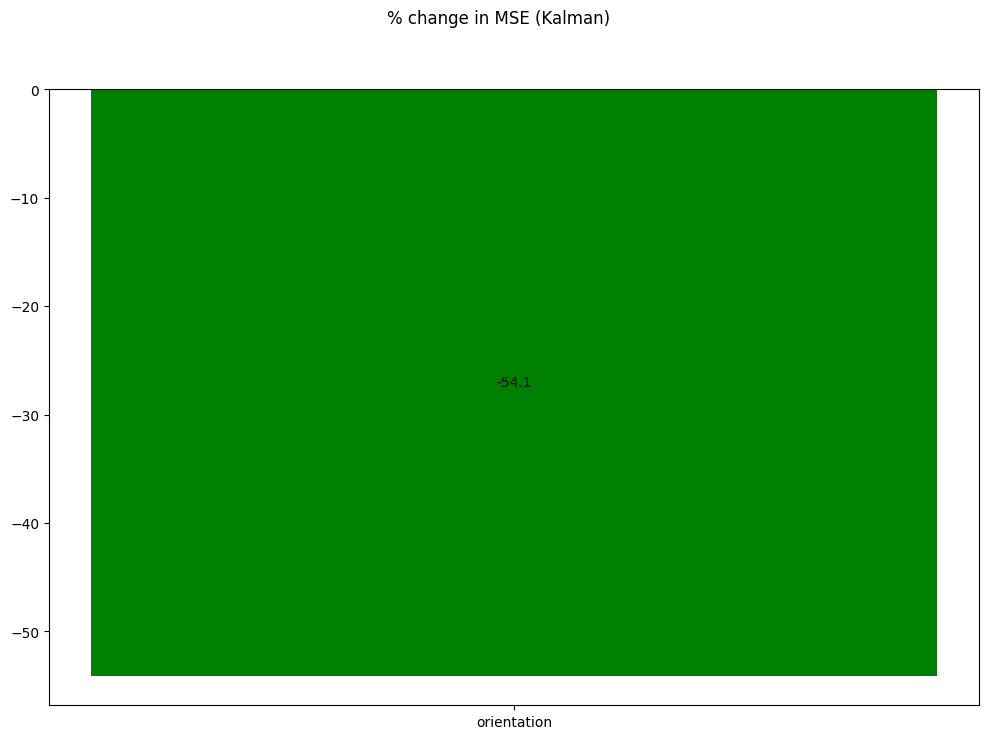

In [8]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.suptitle("% change in MSE (Kalman)")

baseline_th = mean_circular_squared_error(CLEAN_FD, NOISY_FD, TH_COL)
error_th = mean_circular_squared_error(CLEAN_FD, NOISY_KALMAN_FD, TH_COL)
delta_th = percentage_diff(baseline_th, error_th)

deltas = [delta_th]
colours = ['#ffa099' if d > 0 else 'green' for d in deltas]
bars = ax.bar([TH_COL], deltas, color=colours)
ax.bar_label(bars, label_type='center')